#### This code will consolidate all the logs from DataDog, CAL and FPTI and save it in another table in chronological order . E.g. this consolidates the logs for 2025-01-15 from 9 to 10 am.

In [75]:
import pandas as pd

df = None
# Load CSV files with proper datetime parsing
def consolidate(start_time, end_time):
    global df
    df_dd = pd.read_csv("datadog_mobile_logs.csv", parse_dates=["timestamp"])
    df_be = pd.read_csv("backend_logs.csv", parse_dates=["timestamp"])
    df_as = pd.read_csv("analytics_logs.csv", parse_dates=["timestamp"])

    # Filter logs by the time window
    df_dd = df_dd[(df_dd["timestamp"] >= start_time) & (df_dd["timestamp"] <= end_time)]
    df_be = df_be[(df_be["timestamp"] >= start_time) & (df_be["timestamp"] <= end_time)]
    df_as = df_as[(df_as["timestamp"] >= start_time) & (df_as["timestamp"] <= end_time)]

    # Consolidate logs by merging on session_id, event_idx, and event_name.
    # This join will include BE logs only for events that have a backend call (i.e. where a correlation_id exists in DD).
    df_consolidated = pd.merge(
        df_dd,
        df_be,
        on=["session_id", "event_idx", "event_name"],
        how="left",
        suffixes=("_dd", "_be")
    )

    # Now merge the Analytics logs (which don't include correlation_id) on session_id, event_idx, and event_name.
    df_consolidated = pd.merge(
        df_consolidated,
        df_as,
        on=["session_id", "event_idx", "event_name"],
        how="left"
    )

    # Optional: sort the consolidated DataFrame by session_id and event_idx
    df_consolidated.sort_values(by=["session_id", "event_idx"], inplace=True)

    # Display a sample of the consolidated snapshot
    # print("Consolidated Logs Snapshot:")
    # print(df_consolidated.head(10))
    # Save the consolidated view to CSV if desired
    df_consolidated.to_csv("consolidated_logs.csv", index=False)
    df = df_consolidated
    return df_consolidated

In [126]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import datetime

# =============================================================================
# Helper Functions
# =============================================================================

# Assume that you already have the consolidation logic available.
# For our script, we define a helper that calls your consolidation function.
# The consolidation function is expected to set a global variable (df) or return the consolidated DataFrame.
def get_consolidated_logs(start_time, end_time):
    # Call your consolidation function. (Make sure your consolidate() returns a DataFrame or sets a global variable.)
    return consolidate(start_time, end_time)  # Your provided function; it prints/saves, but also sets global df.
    # global df
    # return df

# Parse the Time_Window field which might either be a list or a single interval.
def parse_time_window(time_window_str):
    """
    Parses the Time_Window string into a list of (start, end) tuples.
    Expected formats:
      - "['2025-01-17 09:38:37 - 2025-01-17 11:10:29', ...]"
      - "2025-02-01 02:00:00 - 2025-02-01 06:00:00"
    """
    intervals = []
    try:
        # If the string looks like a list (begins with '['), use literal_eval
        if time_window_str.strip().startswith('['):
            windows = ast.literal_eval(time_window_str)
        else:
            windows = [time_window_str]
        # Each window should be of the form "start_time - end_time"
        for window in windows:
            parts = window.split(' - ')
            if len(parts) == 2:
                start_str, end_str = parts[0].strip(), parts[1].strip()
                start = pd.to_datetime(start_str)
                end = pd.to_datetime(end_str)
                intervals.append((start, end))
    except Exception as e:
        print("Error parsing time window:", e)
    return intervals

# Feature extraction from the consolidated logs DataFrame.
def extract_features_from_logs(df_logs):
    """
    Extract features from the consolidated logs with extra focus on error/failure events.
    
    Features include:
      - total_events: Total number of events in the logs.
      - error_event_count: Count of events with "error" or "failure" in the event name or log_message.
      - error_event_ratio: Ratio of error events to total events.
      - Specific event counts for error events (if applicable).
    """
    features = {}
    if df_logs is None or df_logs.empty:
        features['total_error_events'] = 0
        features['error_event_ratio'] = 0.0
        return features

    # features['total_error_events'] = len(df_logs)
    
    # Define keywords to filter on (case-insensitive)
    keywords = ["error", "failure", "outage"]
    total_error_event_count = 0

    # Count error/failure occurrences either in event_name or in log_message
    for _, row in df_logs.iterrows():
        event_name = str(row.get("event_name", "")).lower()
        log_message = str(row.get("log_message", "")).lower()
        if any(keyword in event_name for keyword in keywords) or any(keyword in log_message for keyword in keywords):
            total_error_event_count += 1

    features['total_error_events'] = total_error_event_count

    # Additionally, record counts for specific error event names for finer granularity:
    max_error_event_count = 0
    event_name_counts = df_logs["event_name"].value_counts().to_dict()
    for event, count in event_name_counts.items():
        # Convert event name to lower case for matching and filtering
        if any(keyword in event.lower() for keyword in keywords):
            features[f'event_{event}'] = count
            if count > max_error_event_count:
                max_error_event_count = count
    if total_error_event_count > 0:
        features['error_event_ratio'] = max_error_event_count / total_error_event_count
    else:
        features['error_event_ratio'] = 0.0

    return features

def extract_static_features(row):
    """
    Extract static fields from the Jira ticket.
    You can customize which fields to include; here we add Project, Summary, and Description.
    """
    features = {}
    # features['Project'] = row.get("Project", "")
    features['Summary'] = row.get("Summary", "")
    features['Description'] = row.get("Description", "")
    # You can add more fields if needed.
    return features

# =============================================================================
# Training Phase
# =============================================================================

# Load your training data with the RCA labels.
df_training = pd.read_csv("jira_tickets_training.csv", parse_dates=["Created_Date"])

# Prepare lists to hold feature dictionaries and labels.
train_feature_dicts = []
train_labels = []

# For each training ticket, process its time windows to build features.
# For each Jira ticket, create a separate training example per time window.
for idx, row in df_training.iterrows():
    time_window_str = row['Time_Window']
    intervals = parse_time_window(time_window_str)
    # Extract static features that are common for all windows in this ticket.
    static_features = extract_static_features(row)
    label = row['RCA']
    
    # Create one training sample for each interval in the time window(s)
    for (start, end) in intervals:
        logs = get_consolidated_logs(start, end)
        log_features = extract_features_from_logs(logs)
        # Merge log-derived features with the static features from the ticket.
        combined_features = {**static_features, **log_features}
        train_feature_dicts.append(combined_features)
        train_labels.append(label)

# Vectorize the feature dictionaries.
dv = DictVectorizer(sparse=False)
X_train_features = dv.fit_transform(train_feature_dicts)

# Encode the RCA labels (assumes a limited set of unique RCAs).
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)

# For demonstration, split the training set for evaluation.
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_features, y_train_encoded, test_size=0.1, random_state=42
)

# Train a RandomForest classifier.
clf = RandomForestClassifier(random_state=42)
clf.fit(X_tr, y_tr)
y_val_pred = clf.predict(X_val)
print("Classification Report on Training Data:")
unique_labels = np.unique(y_val)
print(classification_report(
    y_val, 
    y_val_pred, 
    labels=unique_labels, 
    target_names=le.inverse_transform(unique_labels)
))

# =============================================================================
# Prediction Phase for jira_tickets_cv.csv
# =============================================================================

# Load CV tickets.
df_cv = pd.read_csv("jira_tickets_cv.csv", parse_dates=["Created_Date"])
cv_feature_dicts = []
cv_issue_ids = []

for idx, row in df_cv.iterrows():
    time_window_str = row['Time_Window']
    intervals = parse_time_window(time_window_str)
    static_features = extract_static_features(row)
    # Create one training sample per time window for this issue.
    for (start, end) in intervals:
        logs = get_consolidated_logs(start, end)
        log_features = extract_features_from_logs(logs)
        combined_features = {**static_features, **log_features}
        cv_feature_dicts.append(combined_features)
        # Save issue id; if multiple windows per issue, you might later aggregate predictions.
        cv_issue_ids.append(row['Issue_ID'])
# Transform the feature dictionary to match training features.
X_cv_features = dv.transform(cv_feature_dicts)
cv_preds = clf.predict(X_cv_features)
pred_rcas = le.inverse_transform(cv_preds)

# Combine predictions with their corresponding Issue_ID.
df_cv_predictions = pd.DataFrame({
    "Issue_ID": cv_issue_ids,
    "Predicted_RCA": pred_rcas
})
print("Predictions for jira_tickets_cv:")
df_cv_predictions

Classification Report on Training Data:
                                                                   precision    recall  f1-score   support

                                            Article vendor outage       1.00      1.00      1.00         4
Audio Service not returning soundbytes. Probably TTS Service Down       1.00      1.00      1.00         3
               Video Service Overloaded. Possibly Peak Time Issue       1.00      1.00      1.00         2

                                                         accuracy                           1.00         9
                                                        macro avg       1.00      1.00      1.00         9
                                                     weighted avg       1.00      1.00      1.00         9

Predictions for jira_tickets_cv:


,Issue_ID,Predicted_RCA
0,JIRA-CV-001,Article vendor outage
1,JIRA-CV-002,Video Service Overloaded. Possibly Peak Time I...
2,JIRA-CV-003,Login vendor is throwing an error. Please chec...
3,JIRA-CV-004,Audio Service not returning soundbytes. Probab...


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Debugging: Compare Feature Vectors Between Correctly and Incorrectly Classified Samples --- #

# Suppose you have:
# - X_train_features: your feature matrix from the training phase (from DictVectorizer)
# - y_train_encoded: label-encoded true RCA values
# - clf: your trained RandomForest classifier
# - dv: your DictVectorizer object
# - le: your LabelEncoder object

# Get predictions on the training set.
def print_feature_vectors_importance():
    y_train_pred = clf.predict(X_train_features)

    # Create a DataFrame for easier comparison.
    feature_names = dv.get_feature_names_out()  # requires scikit-learn 1.0+
    df_features = pd.DataFrame(X_train_features, columns=feature_names)
    df_features['True_RCA'] = le.inverse_transform(y_train_encoded)
    df_features['Predicted_RCA'] = le.inverse_transform(y_train_pred)

    # Print samples where prediction was incorrect.
    misclassified = df_features[df_features['True_RCA'] != df_features['Predicted_RCA']]
    print("Misclassified Samples:")
    print(misclassified)

    # Optionally, if there is only one misclassification, examine it in detail:
    if misclassified.shape[0] == 1:
        print("Detailed view for the misclassified sample:")
        print(misclassified)  # Transposed view for easier comparison

    # --- Debugging: Feature Importance Analysis --- #

    importances = clf.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    print("\nTop features by importance:")
    print(importance_df.head(10))

    # Plot the top 10 features to visually inspect which features are weighted highest.
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel("Feature Importance")
    plt.title("Top 10 Features")
    plt.gca().invert_yaxis()  # Invert so the highest importance is on top
    plt.show()

Misclassified Samples:
Empty DataFrame
Columns: [Description=Audio articles reported errors in this time window., Description=Sessions using Twitter login encountered failures for a prolonged period., Description=Too many video streaming failure events in this time window, Description=Users reported that AP articles were not loading in this time window, Summary=Articles not loading, Summary=Audio Articles Error, Summary=Twitter Login Failure, Summary=Video Streaming Failure, error_event_ratio, event_ArticleError, event_AudioArticleError, event_LoginResultFailure, event_VideoArticleError, total_error_events, True_RCA, Predicted_RCA]
Index: []

Top features by importance:
                                              feature  importance
5                        Summary=Audio Articles Error    0.139442
7                     Summary=Video Streaming Failure    0.139043
0   Description=Audio articles reported errors in ...    0.114182
2   Description=Too many video streaming failure e...    

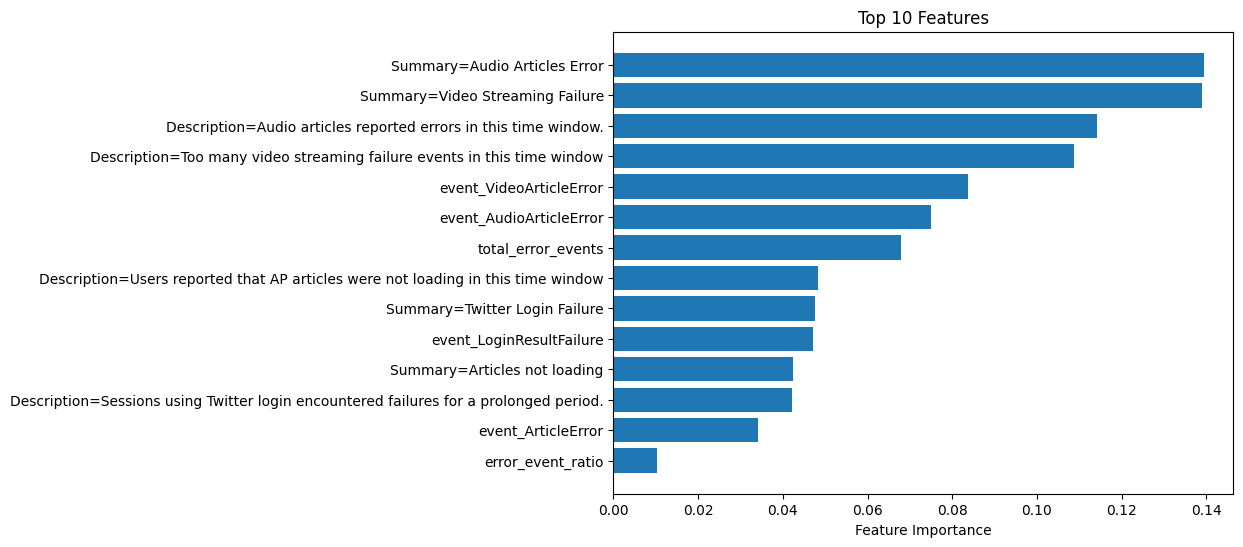

In [128]:
print_feature_vectors_importance()

In [122]:
 # Define a time window for consolidation (adjust as needed)
# '2025-01-21 18:52:53 - 2025-01-21 19:11:46', 
# '2025-01-15 22:22:13 - 2025-01-15 22:50:17', 
# '2025-01-13 09:10:44 - 2025-01-13 09:26:19', 
# '2025-01-16 08:54:53 - 2025-01-16 09:17:53', 
# '2025-01-06 06:23:57 - 2025-01-06 06:50:22', 
# '2025-01-03 16:23:42 - 2025-01-03 16:52:58', 
# '2025-01-29 11:27:04 - 2025-01-29 11:55:31', 
# '2025-01-19 04:44:03 - 2025-01-19 04:55:12', 
# '2025-01-07 10:16:18 - 2025-01-07 10:28:52', 
# '2025-01-31 03:43:25 - 2025-01-31 04:05:10', 
# '2025-01-07 21:29:32 - 2025-01-07 21:56:43', 
# '2025-01-30 02:58:41 - 2025-01-30 03:18:52', 
# '2025-01-30 14:05:40 - 2025-01-30 14:34:51', 
# '2025-01-28 19:49:34 - 2025-01-28 20:04:12', 
# '2025-01-05 09:00:32 - 2025-01-05 09:14:09', 
# '2025-01-08 12:48:44 - 2025-01-08 13:05:30', 
# '2025-01-02 08:19:15 - 2025-01-02 08:45:38', '2025-01-30 15:09:07 - 2025-01-30 15:23:00', '2025-01-23 05:39:46 - 2025-01-23 05:53:28', '2025-01-18 07:16:59 - 2025-01-18 07:40:22', '2025-01-15 02:58:02 - 2025-01-15 03:13:11', '2025-01-28 15:09:15 - 2025-01-28 15:25:16', '2025-01-09 20:33:53 - 2025-01-09 20:57:52', '2025-01-06 12:20:51 - 2025-01-06 12:37:45', '2025-01-09 23:29:27 - 2025-01-09 23:44:24', '2025-01-03 03:35:11 - 2025-01-03 03:50:45', '2025-01-14 22:41:55 - 2025-01-14 23:04:51', '2025-01-21 05:57:33 - 2025-01-21 06:23:37', '2025-01-25 22:13:52 - 2025-01-25 22:34:41', '2025-01-06 11:24:48 - 2025-01-06 11:41:54', '2025-01-14 18:22:01 - 2025-01-14 18:45:27', '2025-01-10 07:14:43 - 2025-01-10 07:39:12']"
start_time = pd.to_datetime("2025-01-25 18:25:04")
end_time   = pd.to_datetime("2025-01-25 18:52:45")
consolidate(start_time, end_time)

,timestamp_dd,session_id,event_idx,event_name,platform,log_message_dd,article_id_dd,correlation_id_dd,timestamp_be,correlation_id_be,service,log_message_be,article_id_be,timestamp,event_type,log_message,article_id
9,2025-01-25 18:36:26,sess-A12258,1,Splash,Android,SplashScreenActivity displayed,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2025-01-25 18:36:26,impression,SplashScreenActivity impression recorded,NaN
10,2025-01-25 18:36:32,sess-A12258,2,LoginPage,Android,LoginActivity displayed,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2025-01-25 18:36:32,impression,LoginActivity impression recorded,NaN
11,2025-01-25 18:36:43,sess-A12258,3,LoginAttempt,Android,User submitted credentials in LoginActivity,NaN,CORR-sess-A12258-3,2025-01-25 18:36:43,CORR-sess-A12258-3,NaN,Authentication request received,NaN,2025-01-25 18:36:43,click,Login button clicked in LoginActivity,NaN
12,2025-01-25 18:36:58,sess-A12258,4,LoginResultFailure,Android,LoginActivity: Login failed,NaN,CORR-sess-A12258-4,2025-01-25 18:36:58,CORR-sess-A12258-4,NaN,Invalid credentials,NaN,2025-01-25 18:36:58,impression,Login failure recorded from LoginActivity,NaN
13,2025-01-25 18:37:10,sess-A12258,5,Exit,Android,User exited app from LastScreenActivity,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2025-01-25 18:37:10,impression,Exit event recorded,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2025-01-25 18:29:14,sess-I29716,1,Splash,iOS,SplashScreenViewController displayed,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2025-01-25 18:29:14,impression,SplashScreenViewController impression recorded,NaN
97,2025-01-25 18:29:45,sess-I29716,2,Home,iOS,HomeScreenViewController displayed,NaN,CORR-sess-I29716-2,2025-01-25 18:29:45,CORR-sess-I29716-2,NaN,Fetching home articles,NaN,2025-01-25 18:29:45,impression,HomeScreenViewController impression recorded,NaN
98,2025-01-25 18:30:07,sess-I29716,3,ArticleError,iOS,ArticleErrorScreen: cnn52851638 from cnn Artic...,cnn52851638,CORR-sess-I29716-3,2025-01-25 18:30:07,CORR-sess-I29716-3,NaN,External API for cnn articles not responding; ...,cnn52851638,2025-01-25 18:30:07,impression,ArticleErrorScreen: Article Error Screen impre...,cnn52851638
99,2025-01-25 18:31:02,sess-I29716,4,ArticleAudio,iOS,ArticleAudioViewController opened,bbc33554233,CORR-sess-I29716-4,2025-01-25 18:31:02,CORR-sess-I29716-4,NaN,Streaming audio started,bbc33554233,2025-01-25 18:31:02,impression,ArticleAudioViewController impression recorded,bbc33554233


In [123]:
# Find a session with session_id = sess-I14083
df = pd.read_csv("consolidated_logs.csv")
print(df['event_name'].value_counts().get('ArticleError', 0))
print(df['event_name'].value_counts().get('LoginResultFailure', 0))
print(df['event_name'].value_counts().get('VideoArticleError', 0))
print(df['event_name'].value_counts().get('AudioArticleError', 0))




8
2
0
0
